In [1]:
import sys

from src.gauss_hist import get_gauss_stats

PWD = '../../..'
sys.path.append(PWD)

import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
from tensorflow.keras import optimizers

from src.network_utils import count_params, plot_difference_hist
from src.cross_validator import CrossValidator
from src.dataset import load_dataset_train_test
from src.models import optimal_model_builders_ch_2_11 as optimal_model_builders

In [2]:
PROJECT_NAME = 'compare'

PLANE = 2
CHANNEL = 11

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'
CROSSVAL_DIR = PWD + f'/data/model_selection/channel_{PLANE}_{CHANNEL}/cross_val'

LR = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048
MAX_TRIALS = 40
EXECUTIONS_PER_TRIAL = 2

TOP_N = 5
CROSSVAL_N_CV = 5
CROSSVAL_N_EXEC = 2
LOSS_WEIGHT = 1000

In [3]:
X_base_train, _, y_base_train, _ = load_dataset_train_test(PWD, PLANE, CHANNEL)

X_base_train.shape

(22412, 24)

In [4]:
def gaussian_kernel(mu, sigma=1., n=24):
    x = np.arange(0, n)
    return np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))


y_base_train_heatmap = np.array([gaussian_kernel(y) for y in y_base_train])

y_base_train_heatmap.shape

(22412, 24)

In [5]:
def compile_wrapper(builder):
    def compiled_builder():
        model = builder()
        model.compile(loss='mse', optimizer=optimizers.Adam(LR), loss_weights=LOSS_WEIGHT)
        return model

    return compiled_builder

# Regular models

Number of parameters: 29953
Got score: 84.4156 (84.3274, 84.5038)
Got score: 83.9809 (83.8945, 84.0674)
Got score: 81.9383 (82.1743, 81.7024)
Got score: 83.6440 (83.8956, 83.3924)
Got score: 85.4505 (85.4315, 85.4695)


Number of parameters: 13201
Got score: 84.7006 (84.5157, 84.8855)
Got score: 83.6207 (83.3821, 83.8594)
Got score: 82.0924 (82.0743, 82.1104)
Got score: 83.3453 (83.3236, 83.3670)
Got score: 85.4526 (85.3558, 85.5495)


Number of parameters: 12931
Got score: 85.0154 (85.0331, 84.9976)
Got score: 84.2145 (84.1698, 84.2592)
Got score: 81.6254 (81.7595, 81.4912)
Got score: 83.7619 (83.7422, 83.7816)
Got score: 85.4924 (85.5319, 85.4530)


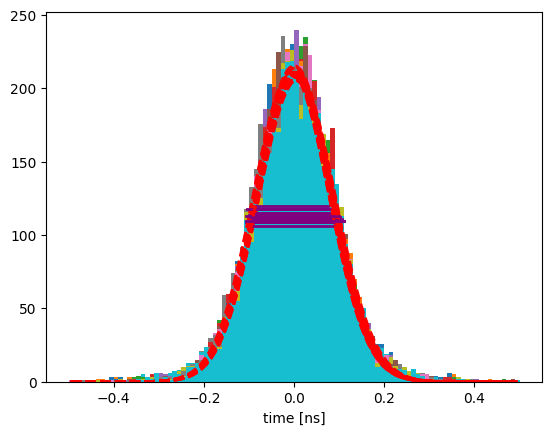

In [6]:
def regular_metric(y_true, y_pred):
    std, _, _ = plot_difference_hist(y_true, y_pred[:, 0], show=False, close=False)
    return std * 1000  # ps


regular_model_builders = [
    compile_wrapper(optimal_model_builders.mlp),
    compile_wrapper(optimal_model_builders.convnet),
    compile_wrapper(optimal_model_builders.rnn),
]
regular_model_names = ['mlp', 'convnet', 'rnn']

cross_validator = CrossValidator(regular_model_builders, X_base_train, y_base_train, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_cv=CROSSVAL_N_CV,
                                 n_executions=CROSSVAL_N_EXEC, model_names=regular_model_names,
                                 eval_metric=regular_metric, overwrite=False)

regular_model_scores = cross_validator()

# Heatmap-based models

Number of parameters: 30051


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


Got score: 85.2360 (84.7598, 85.7122)
Got score: 84.2651 (84.3729, 84.1573)
Got score: 81.7566 (81.8919, 81.6214)
Got score: 84.3836 (84.0622, 84.7050)
Got score: 85.7948 (85.8137, 85.7760)


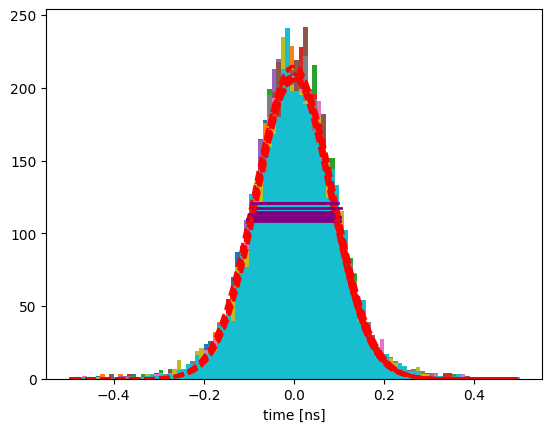

In [7]:
def heatmap_metric(y_heatmap_true, y_heatmap_pred):
    x = np.arange(24)

    y_true = np.empty(y_heatmap_true.shape[0])
    for i, y in enumerate(y_heatmap_true):
        _, y_true[i], _, _ = get_gauss_stats(x, y, a_0=1, std_0=1.)

    y_pred = np.empty(y_heatmap_pred.shape[0])
    for i, y in enumerate(y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(x, y, a_0=1, std_0=1.)

    std, _, _ = plot_difference_hist(y_true, y_pred, show=False, close=False)
    return std * 1000  # ps


heatmap_model_builders = [compile_wrapper(optimal_model_builders.unet)]
heatmap_model_names = ['unet']

cross_validator = CrossValidator(heatmap_model_builders, X_base_train, y_base_train_heatmap, CROSSVAL_DIR, PROJECT_NAME,
                                 n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, n_cv=CROSSVAL_N_CV,
                                 n_executions=CROSSVAL_N_EXEC, model_names=heatmap_model_names,
                                 eval_metric=heatmap_metric, overwrite=False)

heatmap_model_scores = cross_validator()

# Comparison

In [8]:
all_model_builders = regular_model_builders + heatmap_model_builders
all_model_names = regular_model_names + heatmap_model_names
all_model_scores = regular_model_scores | heatmap_model_scores

In [9]:
mean_scores = [f"{np.mean(scores):0.2f}" for scores in all_model_scores.values()]
std_scores = [f"{np.std(scores):0.2f}" for scores in all_model_scores.values()]
n_params = [count_params(builder()) for builder in all_model_builders]

df = pd.DataFrame({'mean': mean_scores, 'std': std_scores, 'n_params': n_params}, index=all_model_scores.keys())
df.index.name = 'Model'
df

,mean,std,n_params
Model,,,
mlp,83.89,1.15,29953
convnet,83.84,1.16,13201
rnn,84.02,1.34,12931
unet,84.29,1.38,30051
